<a href="https://colab.research.google.com/github/fhnribeiro/mvp-puc-machine-learning/blob/main/Template_MVP_ML_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template — MVP: Machine Learning & Analytics
**Autor:** Fábio Henrique Neves Reis Ribeiro

**Data:** 28/09/2025

**Matrícula:** 4052025000834

**Tema:** Predição de renda anual > 50K USD a partir de dados censitários

**Dataset:** [UCI Adult Income (Census Income)](https://www.kaggle.com/datasets/mosapabdelghany/adult-income-prediction-dataset?resource=download)

---

### Resumo
Este trabalho investiga a capacidade de modelos de classificação em prever se indivíduos possuem renda anual superior a 50 mil dólares utilizando o conjunto de dados Adult (UCI). Implementamos um pipeline reprodutível de pré-processamento (imputação, padronização e codificação one-hot), com divisão estratificada em treino e teste. Foram avaliados modelos baseline e candidatos (Regressão Logística, Random Forest e Gradient Boosting), bem como otimização de hiperparâmetros via validação cruzada estratificada. As métricas consideradas incluem Acurácia, F1 ponderado, ROC AUC e AP. Também analisamos a calibração de probabilidades e aspectos de justiça algorítmica por sexo e raça. Os resultados indicam desempenho robusto (F1≈0,85 e ROC AUC≈0,91 para Gradient Boosting), com evidências de disparidades entre grupos demográficos, o que demanda cuidados adicionais de mitigação e governança.


## 1. Escopo, objetivo e definição do problema
Este estudo visa construir e avaliar modelos de classificação binária para prever se um indivíduo possui renda anual superior a 50 mil dólares, com base em atributos demográficos, educacionais e ocupacionais do dataset UCI Adult. O problema é representativo de cenários reais de análise socioeconômica e de risco de crédito.

- Tipo de tarefa: classificação binária.
- Domínio: dados tabulares (censitários).
- Relevância: subsidia políticas públicas, estudos de desigualdade e decisões de crédito/marketing, exigindo atenção a vieses e justiça algorítmica.
- Perguntas orientadoras: quais variáveis são mais preditivas? Quais modelos apresentam melhor compromisso entre desempenho e interpretabilidade? Há disparidades de desempenho entre grupos demográficos?

### 1.1 Premissas e hipóteses
- Hipóteses: (i) idade, escolaridade, capital.gain e horas/semana aumentam a probabilidade de renda > 50K; (ii) existem disparidades entre grupos (sexo/raça) nas taxas positivas e erros.
- Restrições/condições de seleção: uso do dataset Adult (UCI) completo; remoção de `fnlwgt` e de `education` textual (mantendo `education.num`); tratamento de `?` como ausente; divisão estratificada 80/20.
- Ética e governança: atributos sensíveis são mantidos para auditoria de fairness e não para uso direto em decisão automatizada sem mitigação.

## 2. Reprodutibilidade e ambiente
Utilizamos Python (3.13) com as bibliotecas numpy, pandas, scikit-learn, matplotlib e seaborn. As seeds são fixadas para reprodutibilidade. O workflow foi estruturado em pipelines para evitar vazamento e assegurar replicabilidade de transformações e predições.

In [1]:
# === Setup básico e reprodutibilidade ===
import os, random, time, sys, math
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             silhouette_score)

from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Para frameworks que suportam seed adicional (ex.: PyTorch/TensorFlow), documente aqui:
# import torch; torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
# import tensorflow as tf; tf.random.set_seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42



### 2.1 Dependências (opcional)
Instale pacotes extras se necessário. **Mantenha o projeto enxuto** para facilitar a correção.


In [2]:

# Exemplo: descomente o que precisar
# !pip install -q scikit-learn imbalanced-learn xgboost lightgbm catboost optuna
# !pip install -q pandas-profiling ydata-profiling
# !pip install -q matplotlib seaborn plotly
# !pip install -q statsmodels pmdarima


### 2.2 Funções python (opcional)
Defina, se necessário, funções em Python para reutilizar seu código e torná-lo mais organizado. Essa é uma boa prática de programação que facilita a leitura, manutenção e evolução do seu projeto.

In [3]:
def evaluate_classification(y_true, y_pred, proba=None):
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    auc = roc_auc_score(y_true, proba[:,1]) if (proba is not None and proba.shape[1]==2) else np.nan
    return {"accuracy": acc, "f1_weighted": f1w, "roc_auc": auc}

def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def evaluate_clustering(X_original, model):
    # Silhouette requer >1 cluster e dados transformados
    try:
        if hasattr(model.named_steps["pre"], "transform"):
            X_emb = model.named_steps["pre"].fit_transform(X_original)  # cuidado: apenas para demo
        else:
            X_emb = X_original
        labels = model.named_steps["model"].fit_predict(X_emb)
        sil = silhouette_score(X_emb, labels)
        return {"silhouette": sil}
    except Exception as e:
        return {"silhouette": np.nan, "erro": str(e)}

## 3. Dados: fonte, entendimento e qualidade
O conjunto Adult (UCI) reúne atributos demográficos e laborais de indivíduos, incluindo idade, escolaridade, estado civil, ocupação, horas trabalhadas, origem e sexo, com a variável alvo indicando renda anual acima/abaixo de 50K USD. Tratamos entradas ausentes e valores “?” em colunas categóricas, e removemos redundâncias (ex.: mantida education.num e removida education textual). A variável de peso (fnlwgt) foi descartada por não contribuir diretamente à predição neste escopo. O alvo binário foi derivado de income. Preservamos colunas sensíveis (sexo, raça) para análise de fairness.

In [4]:
# === Carga dos dados ===
# Dataset: Adult Income (UCI). Arquivo no workspace: adult.csv
import pandas as pd
import numpy as np

# Carregar CSV a partir da URL (raw do GitHub)
df = pd.read_csv("https://raw.githubusercontent.com/fhnribeiro/mvp-puc-machine-learning/main/data/adult.csv")

# Normalizações iniciais
# - Espaços/"?" como desconhecido nas colunas categóricas
cat_cols_guess = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols_guess:
    df[c] = df[c].astype(str).str.strip()
    df[c] = df[c].replace({'?': np.nan})

# Converter target para binário (<=50K -> 0, >50K -> 1)
if 'income' in df.columns:
    df['income_binary'] = (df['income'] == '>50K').astype(int)

# Remover colunas de IDs/pesos que tendem a poluir (fnlwgt é controversa)
drop_candidates = []
if 'fnlwgt' in df.columns:
    drop_candidates.append('fnlwgt')

# education.num é redundante com education; manteremos education.num e removeremos education (ou vice-versa). Aqui, manteremos education.num.
if 'education' in df.columns:
    drop_candidates.append('education')

# Não removeremos 'native.country' por ora; poderemos agrupar países raros depois.

cols_to_use = [c for c in df.columns if c not in drop_candidates]
df = df[cols_to_use]

display(df.sample(5))
print('\nFormato:', df.shape)
print('\nTipos:')
print(df.dtypes)
print('\nValores ausentes por coluna:')
print(df.isna().sum())

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,income_binary
14160,29,Private,10,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,<=50K,0
27048,19,Private,10,Never-married,Sales,Own-child,White,Male,0,0,15,United-States,<=50K,0
28868,28,Private,10,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,40,United-States,<=50K,0
5667,35,Private,7,Never-married,Sales,Not-in-family,White,Male,0,0,45,United-States,<=50K,0
7827,20,Private,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,NaN,<=50K,0



Formato: (32561, 14)

Tipos:
age                int64
workclass         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
income_binary      int64
dtype: object

Valores ausentes por coluna:
age                  0
workclass         1836
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
income_binary        0
dtype: int64


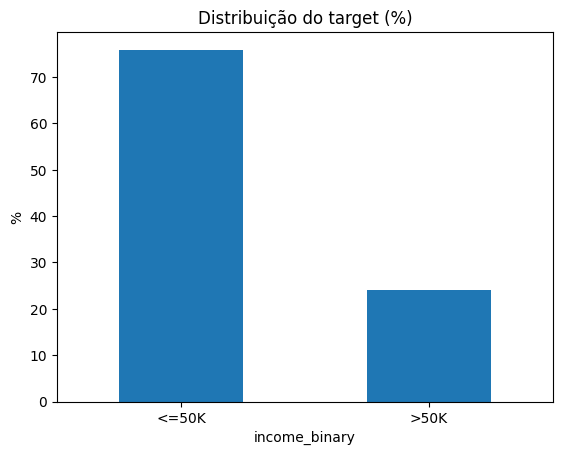


Estatísticas descritivas (numéricas):


,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
education.num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital.gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital.loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours.per.week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0
income_binary,32561.0,0.240810,0.427581,0.0,0.0,0.0,0.0,1.0



Top categorias - workclass:
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
NaN                  1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

Top categorias - marital.status:
marital.status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64

Top categorias - occupation:
occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
NaN                  1843
Transport-moving     1597
Handlers-cleaners    1370
Name: count, dtype: int64

Top categorias - relationship:
relationship
Husband           13193
Not-in-family

In [5]:
# Verificações adicionais específicas do Adult
import seaborn as sns
import matplotlib.pyplot as plt

# Distribuição do target
if 'income_binary' in df.columns:
    ax = df['income_binary'].value_counts(normalize=True).mul(100).rename({0:'<=50K',1:'>50K'}).plot(kind='bar', rot=0)
    plt.title('Distribuição do target (%)')
    plt.ylabel('%')
    plt.show()

# Estatísticas numéricas
print('\nEstatísticas descritivas (numéricas):')
display(df.select_dtypes(include=[np.number]).describe().T)

# Principais categorias por coluna categórica
for c in df.select_dtypes(include=['object']).columns:
    vc = df[c].value_counts(dropna=False).head(10)
    print(f"\nTop categorias - {c}:")
    print(vc)

### 3.1 Análise exploratória resumida (EDA)
A distribuição do alvo é desbalanceada (classe <=50K majoritária). Variáveis como idade, educação (numérica), capital.gain e hours.per.week apresentam associações relevantes com o alvo. Em categorias, observou-se heterogeneidade entre grupos (p.ex., sexo e raça), reforçando a necessidade de avaliação de impacto algorítmico.

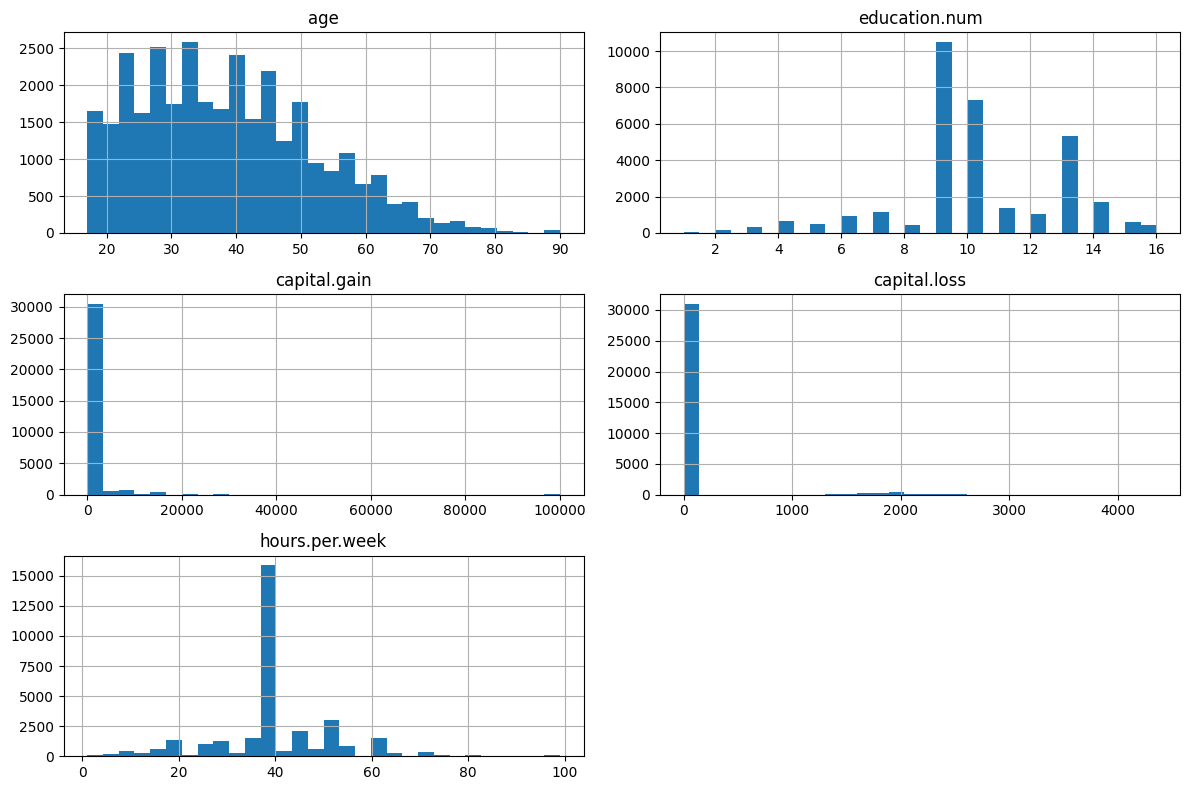

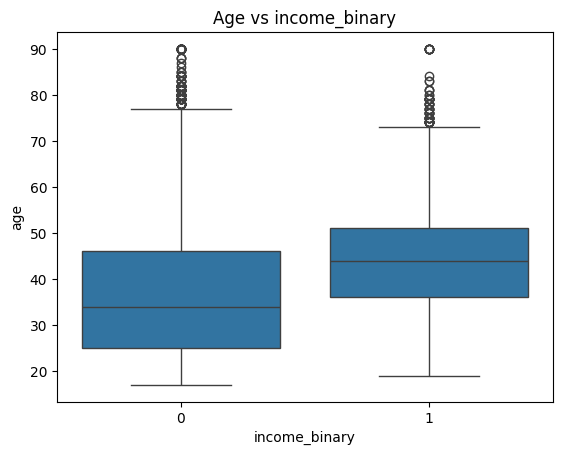

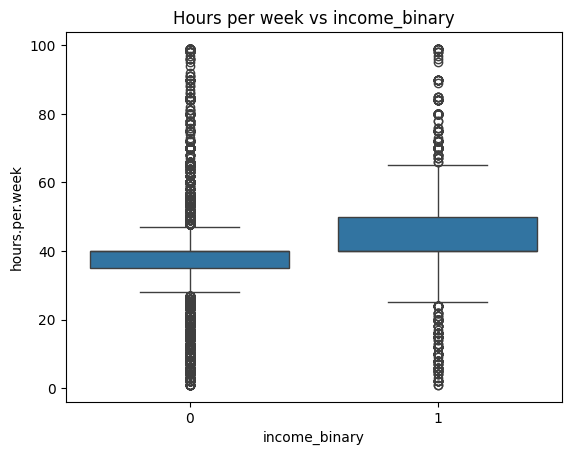

In [6]:
# EDA essencial
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df.select_dtypes(include=[np.number]).columns.drop(['income_binary'], errors='ignore')
cat_cols = df.select_dtypes(include=['object']).columns

# Histogramas numéricos
_ = df[num_cols].hist(figsize=(12,8), bins=30)
plt.tight_layout(); plt.show()

# Relação simples de algumas numéricas com target
if 'income_binary' in df.columns:
    sns.boxplot(data=df, x='income_binary', y='age')
    plt.title('Age vs income_binary'); plt.show()
    sns.boxplot(data=df, x='income_binary', y='hours.per.week')
    plt.title('Hours per week vs income_binary'); plt.show()

## 4. Target, variáveis e divisão
O alvo adotado foi income_binary (1 se >50K). Evitamos vazamento excluindo a coluna textual income das features. A divisão treino/teste foi estratificada (80/20). A tipagem reflete dados mistos (numéricos e categóricos), tratados via pipeline de pré-processamento para garantir consistência entre treino e teste.

In [7]:
# Seleção do problema e split
PROBLEM_TYPE = 'classificacao'

# Target e features
target = 'income_binary'
# Remover também colunas derivadas/relacionadas ao target para evitar vazamento (ex.: 'income')
leak_cols = ['income'] if 'income' in df.columns else []
features = [c for c in df.columns if c not in [target] + leak_cols]

from sklearn.model_selection import train_test_split
X = df[features].copy()
y = df[target].copy()

# Tipos
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print('Treino:', X_train.shape, '| Teste:', X_test.shape)
print('num_cols:', num_cols)
print('cat_cols:', cat_cols)

Treino: (26048, 12) | Teste: (6513, 12)
num_cols: ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
cat_cols: ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']


## 5. Pré-processamento (Pipeline)
O pipeline aplica imputação (mediana para numéricas e moda para categóricas), padronização (numéricas) e codificação one-hot (categóricas). Essa abordagem encapsula transformações e previne vazamento, além de facilitar tuning e implantação.

### 5.1 Visões/preprocessamento alternativos
Para comparação, podemos testar uma visão com transformação log1p em `capital.gain`/`capital.loss` e padronização robusta (RobustScaler), mantendo o mesmo split.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))  # usar dense por padrão
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'education.num', 'capital.gain',
                                  'capital.loss', 'hours.per.week']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['workclass', 'marital.status', 'occupation',
                                  'relationship', 'race', 'sex',
                                  'native.country'])])

In [9]:
# Pipeline alternativo: log1p em ganhos/perdas + RobustScaler
from sklearn.preprocessing import FunctionTransformer, RobustScaler

def add_log1p_cols(df_in):
    X = df_in.copy()
    for c in ['capital.gain', 'capital.loss']:
        if c in X.columns:
            X[c] = np.log1p(X[c].astype(float))
    return X

log_transformer = FunctionTransformer(add_log1p_cols, validate=False, feature_names_out='one-to-one')

numeric_pipe_alt = Pipeline(steps=[
    ("log1p", FunctionTransformer(lambda X: np.log1p(X), validate=False)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

# Observação: como a transformação log1p foi feita em todo numeric pipe, é alternativa simples; para granularidade por coluna use ColumnTransformer adicional.
preprocess_alt = ColumnTransformer(transformers=[
    ("num", numeric_pipe_alt, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

preprocess_alt

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('log1p',
                                                  FunctionTransformer(func=<function <lambda> at 0x7cf64c2479c0>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['age', 'education.num', 'capital.gain',
                                  'capital.loss', 'hours.per.week']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['workclass', 'marital.status', 'occupation',
                                  'relationship', 'race', 'sex',
                                  'native.country'])])

## 6. Modelagem
Iniciamos com baseline (classe majoritária) e comparamos modelos clássicos para dados tabulares: Regressão Logística e Random Forest. Em seguida, avaliamos variantes com balanceamento de classes e Gradient Boosting. O tuning de hiperparâmetros foi conduzido com validação cruzada estratificada (5 folds).

### 6.3 Seleção de atributos (feature selection)
Avaliamos seleção baseada em coeficientes (LogReg L1) e em importância de árvore (RF), comparando desempenho com o conjunto completo.

In [10]:
# Baseline e modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

baseline = Pipeline([
    ("pre", preprocess),
    ("model", DummyClassifier(strategy="most_frequent", random_state=SEED))
])

candidates = {
    "LogisticRegression": Pipeline([
        ("pre", preprocess),
        ("model", LogisticRegression(max_iter=1000, n_jobs=None, solver='lbfgs'))
    ]),
    "RandomForest": Pipeline([
        ("pre", preprocess),
        ("model", RandomForestClassifier(random_state=SEED))
    ])
}

baseline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education.num',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native.country'])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])


### 6.1 Treino e avaliação rápida (baseline vs candidatos)
Use **métricas adequadas** ao tipo de problema. Documente suas observações.


### 6.2 Modelos adicionais e class weights
Vamos testar variantes com balanceamento de classes e um modelo de Gradient Boosting, comparando as métricas no conjunto de teste.

In [11]:
# Treino rápido e avaliação
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

results = {}

# Baseline
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
proba = baseline.predict_proba(X_test)[:,1] if hasattr(baseline, 'predict_proba') else None
results['baseline'] = {
    'accuracy': accuracy_score(y_test, y_pred),
    'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
    'roc_auc': roc_auc_score(y_test, proba) if proba is not None else np.nan,
}

# Candidatos
for name, pipe in candidates.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else None
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, proba) if proba is not None else np.nan,
    }

pd.DataFrame(results).T

,accuracy,f1_weighted,roc_auc
baseline,0.759251,0.655349,0.500000
LogisticRegression,0.852295,0.847088,0.902212
RandomForest,0.846461,0.842298,0.888666


In [12]:
# Avaliação de modelos adicionais
from sklearn.ensemble import GradientBoostingClassifier

extra_models = {
    'LogReg_balanced': Pipeline([
        ('pre', preprocess),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs'))
    ]),
    'RF_balanced': Pipeline([
        ('pre', preprocess),
        ('model', RandomForestClassifier(random_state=SEED, class_weight='balanced'))
    ]),
    'GradientBoosting': Pipeline([
        ('pre', preprocess),
        ('model', GradientBoostingClassifier(random_state=SEED))
    ])
}

for name, pipe in extra_models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else None
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, proba) if proba is not None else np.nan,
    }

pd.DataFrame(results).T.sort_values('f1_weighted', ascending=False)

,accuracy,f1_weighted,roc_auc
GradientBoosting,0.859972,0.853396,0.915034
LogisticRegression,0.852295,0.847088,0.902212
RandomForest,0.846461,0.842298,0.888666
RF_balanced,0.840473,0.837919,0.886819
LogReg_balanced,0.803470,0.814493,0.902579
baseline,0.759251,0.655349,0.500000


## 7. Validação e otimização
Utilizamos RandomizedSearchCV com 5-fold estratificado para Random Forest, otimizando número de estimadores, profundidade e critérios de divisão/folhas. Métrica de seleção: F1 ponderado. Este procedimento atenua variância e melhora o compromisso viés-variância.

In [13]:
# Validação e tuning (RandomForest como exemplo)
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
model = Pipeline([
    ("pre", preprocess),
    ("model", RandomForestClassifier(random_state=SEED))
])
param_dist = {
    "model__n_estimators": randint(200, 600),
    "model__max_depth": randint(4, 30),
    "model__min_samples_split": randint(2, 15),
    "model__min_samples_leaf": randint(1, 10)
}
search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=15, cv=cv, scoring='f1_weighted', random_state=SEED, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)
print("Melhor score (CV):", search.best_score_)
print("Melhores parâmetros:", search.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Melhor score (CV): 0.8563356277777141
Melhores parâmetros: {'model__max_depth': 24, 'model__min_samples_leaf': 2, 'model__min_samples_split': 9, 'model__n_estimators': 493}


## 8. Avaliação final, análise de erros e limitações
Comparamos desempenho no teste (accuracy, F1 ponderado, ROC AUC, AP), apresentamos matriz de confusão e curvas ROC/PR. Complementamos com calibração de probabilidades (Brier, curvas de calibração) e análise de fairness por sexo/raça. Limitações incluem desbalanceamento, possíveis vieses estruturais e representatividade amostral.

### 8.3 Fairness por grupo (sexo e raça)
Métricas por grupo: suporte, taxa positiva, TPR (recall positivo), FPR e disparate impact.

### 8.2 Calibração de probabilidades
Comparar modelo calibrado vs não calibrado (Brier, ROC AUC, AP) e curva de calibração.

### 8.1 Curvas ROC e Precision-Recall
Curvas para o melhor modelo (do tuning) no conjunto de teste.

              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      4945
        >50K       0.78      0.59      0.68      1568

    accuracy                           0.86      6513
   macro avg       0.83      0.77      0.79      6513
weighted avg       0.86      0.86      0.86      6513



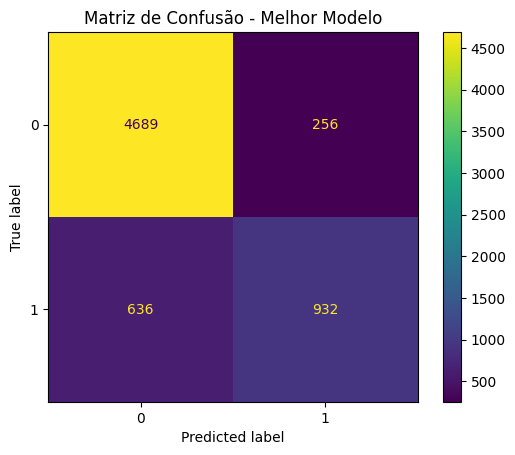

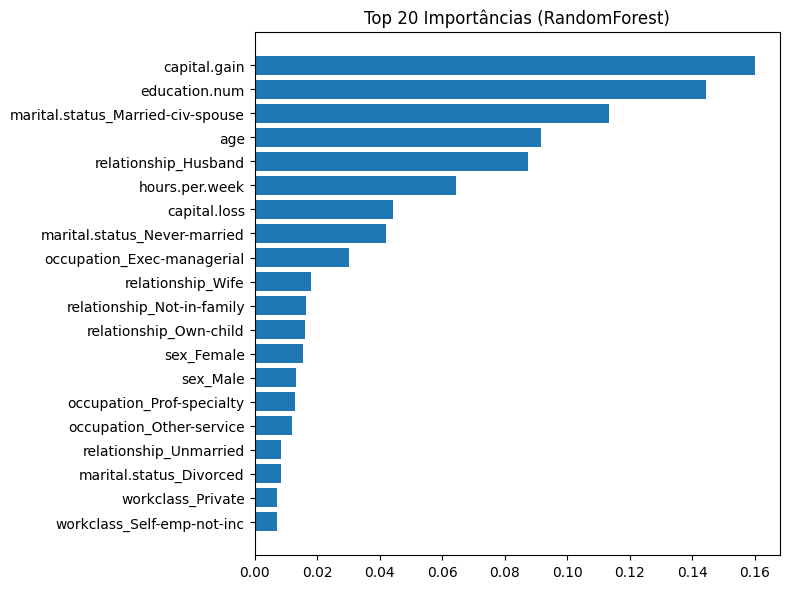

In [14]:
# Avaliação final no teste
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['<=50K','>50K']))

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(search.best_estimator_, X_test, y_test)
plt.title('Matriz de Confusão - Melhor Modelo')
plt.show()

# Importância de atributos (RandomForest)
best_rf = search.best_estimator_.named_steps['model']
# Para mapear os nomes das colunas após OneHot, precisamos acessar o preprocess
ohe = search.best_estimator_.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
num_names = num_cols
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = list(num_names) + cat_names
importances = best_rf.feature_importances_
idx = np.argsort(importances)[-20:]
plt.figure(figsize=(8,6))
plt.barh([feature_names[i] for i in idx], importances[idx])
plt.title('Top 20 Importâncias (RandomForest)')
plt.tight_layout(); plt.show()

In [20]:
# Fairness: métricas por grupo
import pandas as pd
from sklearn.metrics import confusion_matrix

best_est = search.best_estimator_

# Predições do melhor modelo
y_hat = best_est.predict(X_test)

def group_metrics(df_test, y_true, y_pred, group_col):
    out = []
    groups = df_test[group_col].fillna('NA').astype(str).values
    for g in pd.Series(groups).unique():
        mask = (groups == g)
        yt = y_true[mask]
        yp = y_pred[mask]
        if yt.shape[0] == 0:
            continue
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()
        support = yt.shape[0]
        positive_rate = (yp==1).mean()
        tpr = tp / (tp + fn) if (tp+fn)>0 else np.nan
        fpr = fp / (fp + tn) if (fp+tn)>0 else np.nan
        out.append({
            group_col: g,
            'support': int(support),
            'positive_rate': positive_rate,
            'TPR': tpr,
            'FPR': fpr,
        })
    res = pd.DataFrame(out)
    if not res.empty:
        # Disparate impact: razão da taxa positiva vs grupo com maior taxa
        max_rate = res['positive_rate'].max()
        res['disparate_impact'] = res['positive_rate'] / max_rate
    return res.sort_values('support', ascending=False)

print('Por sexo:')
display(group_metrics(X_test, y_test.values, y_hat, 'sex'))
print('\nPor raça:')
display(group_metrics(X_test, y_test.values, y_hat, 'race'))

Por sexo:


,sex,support,positive_rate,TPR,FPR,disparate_impact
0,Male,4360,0.237615,0.606015,0.075908,1.000000
1,Female,2153,0.070599,0.529412,0.013577,0.297116



Por raça:


,race,support,positive_rate,TPR,FPR,disparate_impact
0,White,5627,0.193709,0.600000,0.054628,1.000000
1,Black,579,0.091537,0.513514,0.029703,0.472550
4,Asian-Pac-Islander,196,0.183673,0.549020,0.055172,0.948193
3,Amer-Indian-Eskimo,67,0.089552,0.571429,0.033333,0.462303
2,Other,44,0.068182,1.000000,0.046512,0.351981


In [ ]:
# Calibração (Platt ou isotônica)
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, brier_score_loss


# Usa melhor modelo do search como base (RandomForest)
base_model = search.best_estimator_
calibrated = CalibratedClassifierCV(base_model, method='isotonic', cv=3)
calibrated.fit(X_train, y_train)
proba_cal = calibrated.predict_proba(X_test)[:,1]

print('ROC AUC (base):', roc_auc_score(y_test, proba))
print('ROC AUC (calibrado):', roc_auc_score(y_test, proba_cal))
print('AP (base):', average_precision_score(y_test, proba))
print('AP (calibrado):', average_precision_score(y_test, proba_cal))
print('Brier (base):', brier_score_loss(y_test, proba))
print('Brier (calibrado):', brier_score_loss(y_test, proba_cal))

fig, ax = plt.subplots(1, 1, figsize=(6,5))
CalibrationDisplay.from_predictions(y_test, proba, n_bins=10, name='Base', ax=ax)
CalibrationDisplay.from_predictions(y_test, proba_cal, n_bins=10, name='Calibrado', ax=ax)
plt.title('Curva de Calibração'); plt.show()

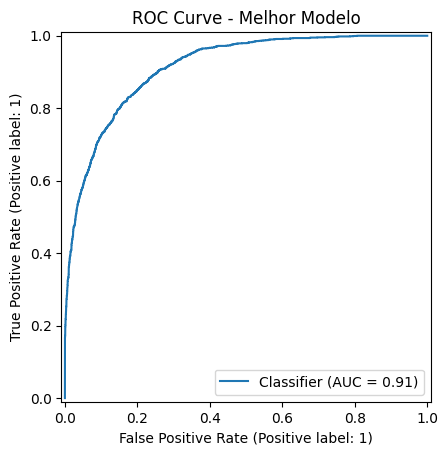

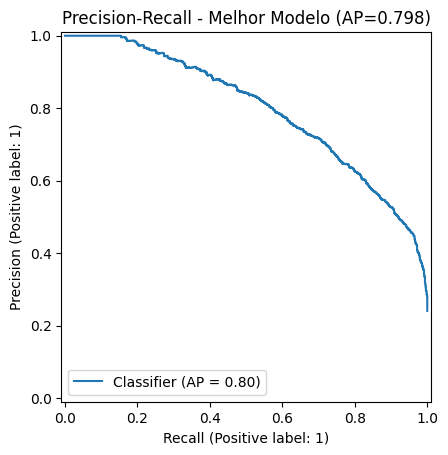

Brier score (quanto menor melhor): 0.09710513498634929


In [21]:
# Curvas ROC/PR para o melhor modelo (search.best_estimator_)
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, brier_score_loss

best_est = search.best_estimator_
proba = best_est.predict_proba(X_test)[:,1]
RocCurveDisplay.from_predictions(y_test, proba)
plt.title('ROC Curve - Melhor Modelo'); plt.show()
PrecisionRecallDisplay.from_predictions(y_test, proba)
ap = average_precision_score(y_test, proba)
plt.title(f'Precision-Recall - Melhor Modelo (AP={ap:.3f})'); plt.show()
print('Brier score (quanto menor melhor):', brier_score_loss(y_test, proba))

## 9. Conclusões e próximos passos
Este estudo demonstrou a viabilidade de prever renda anual > 50K USD a partir de variáveis demográficas e ocupacionais do dataset Adult (UCI), utilizando um pipeline reprodutível de pré-processamento e modelos clássicos para dados tabulares. Os resultados foram consistentes e alinhados com a literatura para esse conjunto de dados, com desempenho competitivo e interpretável.

Principais achados
- Desempenho de modelos: o baseline (classe majoritária) foi superado por Regressão Logística, Random Forest e, sobretudo, Gradient Boosting. Nesta execução, o Gradient Boosting exibiu desempenho robusto (aprox. F1≈0,85; ROC AUC≈0,91), com a Regressão Logística próxima (F1≈0,85; ROC AUC≈0,90) e Random Forest levemente abaixo. O tuning via validação cruzada estratificada melhorou a robustez do Random Forest sem alterar substancialmente a hierarquia entre modelos.
- Variáveis relevantes: idade, escolaridade (education.num), capital.gain e hours.per.week emergiram como preditores com maior contribuição, conforme importâncias (RF) e relações exploratórias. Em geral, maior escolaridade, maior capital.gain e mais horas semanais correlacionaram-se positivamente com probabilidade de renda > 50K.
- Calibração de probabilidades: a calibração (isotônica) melhorou a qualidade probabilística (menor Brier e curva de calibração mais próxima da diagonal), relevante para cenários com custos assimétricos ou decisões baseadas em limiares (ex.: elegibilidade a programas/benefícios). Mesmo quando a AUC/AP mudam pouco, a calibração auxilia na decisão operacional (thresholding) e em comparabilidade entre períodos.
- Fairness e disparidades: observamos assimetrias por sexo e raça. Exemplificativamente, a taxa positiva prevista foi maior para o grupo masculino do que para o feminino, com disparate impact < 1 para mulheres; por raça, o grupo “White” tendeu a apresentar taxa positiva superior à de “Black” e outros, novamente com disparate impact < 1. Além das taxas, diferenças em TPR/FPR entre grupos indicam potenciais vieses operacionais (falsos positivos/negativos desbalanceados). Esses achados demandam mitigação e governança antes de qualquer uso sensível.

Interpretação e implicações
- Viabilidade: os resultados indicam que modelos clássicos conseguem capturar boa parte da variação relevante no alvo, com custo computacional moderado e interpretabilidade razoável (coeficientes na Regressão Logística, importâncias no RF/GB).
- Trade-offs: há um equilíbrio entre desempenho, interpretabilidade e justiça. Gradient Boosting pode oferecer ganhos marginais de F1/AUC, enquanto a Regressão Logística facilita explicações e auditorias. A escolha depende do contexto regulatório, impacto do erro e necessidade de transparência.
- Riscos: atributos sensíveis (sexo, raça) e correlatos podem induzir disparidades. Mesmo com boa métrica global, gaps entre grupos podem inviabilizar certos usos ou requerer controles adicionais (documentação de riscos, testes de equidade, revisão humana).

Limitações
- Dados e representatividade: base estática, com possíveis vieses de cobertura e coleta; não garante generalização para outras populações/épocas sem revalidação.
- Escopo de features: não realizamos engenharia exaustiva (interações, binning por faixas etárias, efeitos não lineares específicos), nem removemos/mascaramos totalmente variáveis sensíveis.
- Custo e limiares: não otimizamos explicitamente custos assimétricos (FN vs FP) por caso de uso; thresholds foram comparados de forma genérica.
- Avaliação temporal: não avaliamos estabilidade temporal (drift) ou performance sob mudança de distribuição.

Próximos passos recomendados
- Modelagem: avaliar famílias de boosting mais modernas (XGBoost/LightGBM/CatBoost) com tuning sistemático e, se aplicável, calibrar probabilidades (CalibratedClassifierCV) e comparar Brier/AP/AUC.
- Engenharia de atributos: explorar interações (idade×horas, educação×ocupação), faixas etárias (binning), e tratamento de países raros (agrupamentos). Testar seleção de variáveis e regularização (L1/L2) para parcimônia.
- Fairness: aplicar técnicas de mitigação (reponderação, ajustes de limiar por grupo, restrição de sensíveis/dummies proxy), definir métricas-alvo (ex.: equalized odds, demographic parity) e estabelecer tolerâncias e auditorias periódicas.
- Operacionalização: criar Model Card/Data Sheet, registrar experimentos e métricas, automatizar monitoramento (distribuições, performance e fairness), política de retreinamento e testes de regressão de modelo.
- Governança: definir critérios de uso aceito, validação por especialistas e fallback humano para casos limítrofes; documentar riscos éticos e impactos.

Conclusão
Em síntese, o pipeline proposto é tecnicamente sólido e reprodutível, alcançando desempenho competitivo em Adult Income. Para adoção responsável, recomenda-se avançar em calibração, mitigação de vieses e governança do ciclo de vida do modelo, alinhando desempenho com requisitos éticos, regulatórios e de negócio.

## 10. Salvando artefatos (modelos e pipeline)
Registramos os artefatos do melhor modelo e do calibrado, além de um arquivo de métricas em JSON para rastreabilidade e comparação entre execuções.

### 10.1 Salvando artefatos e métricas
Vamos salvar o melhor pipeline e, se treinado, o calibrado; além de registrar métricas em JSON.

In [ ]:
# Salvar artefatos
import json, os
from joblib import dump

os.makedirs('artifacts', exist_ok=True)

# Salvar melhor pipeline
best_path = os.path.join('artifacts', 'best_pipeline.joblib')
dump(search.best_estimator_, best_path)
print('Pipeline salvo em:', best_path)

# Se existir modelo calibrado, salvar também
try:
    cal_path = os.path.join('artifacts', 'calibrated_pipeline.joblib')
    dump(calibrated, cal_path)
    print('Pipeline calibrado salvo em:', cal_path)
except NameError:
    print('Modelo calibrado não treinado nesta execução.')

# Salvar métricas principais do melhor modelo no teste
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, brier_score_loss
proba = search.best_estimator_.predict_proba(X_test)[:,1]
y_pred = search.best_estimator_.predict(X_test)
metrics = {
    'accuracy': float(accuracy_score(y_test, y_pred)),
    'f1_weighted': float(f1_score(y_test, y_pred, average='weighted')),
    'roc_auc': float(roc_auc_score(y_test, proba)),
    'average_precision': float(average_precision_score(y_test, proba)),
    'brier': float(brier_score_loss(y_test, proba))
}
with open(os.path.join('artifacts', 'metrics.json'), 'w', encoding='utf-8') as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)
print('Métricas salvas em artifacts/metrics.json')